In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

from models import ConvVAE
from torchvision import datasets, transforms
from tqdm import tqdm
from ResVAE import ResVAE

from torchvision.utils import save_image
import torch.nn.functional as F

from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter
import shutil

f:\Uni\Cuda-Lab\Cuda_Lab\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BSZ = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#We used a smaller version of the dataset because we miscalculated the training time a bit
train_dataset = datasets.CelebA(root="data/", split="train", transform=data_transforms['train'], download=True)
#train_dataset, subtrain_dataset =  torch.utils.data.random_split(train_dataset, [50000, len(train_dataset) - 50000]) 
test_dataset = datasets.CelebA(root="data/", split="test", transform=data_transforms['test'], download=True)
#test_dataset, subtrain_dataset =  torch.utils.data.random_split(test_dataset, [1000, len(test_dataset) - 1000]) 

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BSZ, shuffle=False)

In [6]:
def vae_loss_function(recons, target, mu, log_var, lambda_recons=1, lambda_elbo=1):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    #recons shape bsz*3*16*16 target shape bsz*3*64*64 
    recons_loss = F.mse_loss(recons, target, reduction="sum")
    b_size = recons.shape[0]
    elbo = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (lambda_recons * recons_loss + lambda_elbo * elbo) / b_size, (recons_loss, elbo)

def train_epoch(model, train_loader, optimizer, criterion, epoch, device, tboard):
    """ Training a model for one epoch """
    model.train()

    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
        # tensorboard logging
        step = epoch * len(train_loader) + i
        tboard.add_scalar(f'Loss Iters/Train Loss Iter', loss.item(), global_step=step)
        tboard.add_scalar(f'Loss Iters/Recons Loss Iter', mse.item(), global_step=step)
        tboard.add_scalar(f'Loss Iters/KL Loss Iter', kld.item(), global_step=step)
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, tboard, epoch=None, savefig=False, savepath=""):
    model.eval()
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
#         if(i==0 and savefig):
#             save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            
#         # saving images to tensorboard
#         if i == 0:
#             grid = torchvision.utils.make_grid(images[:64].cpu())
#             tboard.add_image('original', grid, global_step=epoch)
#             grid = torchvision.utils.make_grid(recons[:64].cpu())
#             tboard.add_image('recons', grid, global_step=epoch)
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
        
    return loss

In [7]:
def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, savepath, tboard, save_frequency=5):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                tboard=tboard
            )
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device, tboard=tboard
            )
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            #save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
    
        # tensorboard logging
        tboard.add_scalar(f'Loss/Train Loss', train_loss[-1], global_step=epoch)
        tboard.add_scalar(f'Loss/Valid Loss', val_loss[-1], global_step=epoch)
        tboard.add_scalars(f'Loss/Comb_Loss', {
                'Train': train_loss[-1],
                'Valid': val_loss[-1]
            }, epoch)    
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters

In [8]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
# define the learning parameters
model = ConvVAE().to(device)
lr = 0.001
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [10]:
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 65, 65]           3,136
            Conv2d-2          [-1, 128, 33, 33]         131,200
            Conv2d-3          [-1, 256, 17, 17]         524,544
            Conv2d-4            [-1, 512, 9, 9]       2,097,664
            Conv2d-5           [-1, 1024, 5, 5]       8,389,632
            Linear-6                 [-1, 2048]       2,099,200
            Linear-7                  [-1, 128]         262,272
            Linear-8                  [-1, 128]         262,272
            Linear-9                 [-1, 1024]         132,096
  ConvTranspose2d-10            [-1, 512, 3, 3]       4,719,104
  ConvTranspose2d-11            [-1, 256, 7, 7]       1,179,904
  ConvTranspose2d-12          [-1, 128, 15, 15]         295,040
  ConvTranspose2d-13           [-1, 64, 31, 31]          73,792
  ConvTranspose2d-14            [-1, 3,

In [11]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

In [12]:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

In [13]:
train_loss = []
valid_loss = []

In [14]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, train_dataset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, test_loader, test_dataset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    #save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    #image_grid = make_grid(recon_images.detach().cpu())
    #grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 50


2544it [05:31,  7.66it/s]                          
312it [00:56,  5.52it/s]                         


Train Loss: 1732288.5340
Val Loss: 1651138.0505
Epoch 2 of 50


2544it [06:19,  6.71it/s]                          
312it [00:21, 14.33it/s]                         


Train Loss: 1643695.8467
Val Loss: 1625957.2099
Epoch 3 of 50


2544it [04:09, 10.21it/s]                          
312it [00:22, 13.58it/s]                         


Train Loss: 1626127.0352
Val Loss: 1616139.9487
Epoch 4 of 50


2544it [04:18,  9.84it/s]                          
312it [00:22, 14.06it/s]                         


Train Loss: 1616701.2224
Val Loss: 1605659.6699
Epoch 5 of 50


2544it [04:17,  9.87it/s]                          
312it [00:21, 14.53it/s]                         


Train Loss: 1609738.6806
Val Loss: 1599974.5617
Epoch 6 of 50


2544it [04:13, 10.04it/s]                          
312it [00:22, 14.09it/s]                         


Train Loss: 1603974.4212
Val Loss: 1595732.4944
Epoch 7 of 50


2544it [04:15,  9.94it/s]                          
312it [00:22, 13.99it/s]                         


Train Loss: 1600103.7549
Val Loss: 1591806.3586
Epoch 8 of 50


2544it [04:16,  9.90it/s]                          
312it [00:22, 14.00it/s]                         


Train Loss: 1597260.6126
Val Loss: 1601686.8345
Epoch 9 of 50


2544it [04:10, 10.16it/s]                          
312it [00:21, 14.53it/s]                         


Train Loss: 1594589.3199
Val Loss: 1586863.6851
Epoch 10 of 50


2544it [04:15,  9.98it/s]                          
312it [00:22, 13.82it/s]                         


Train Loss: 1592627.8853
Val Loss: 1586127.1438
Epoch 11 of 50


2544it [04:14, 10.01it/s]                          
312it [00:21, 14.55it/s]                         


Train Loss: 1590762.2305
Val Loss: 1585033.9363
Epoch 12 of 50


2544it [04:11, 10.11it/s]                          
312it [00:21, 14.33it/s]                         


Train Loss: 1589086.5386
Val Loss: 1583016.9732
Epoch 13 of 50


2544it [04:10, 10.15it/s]                          
312it [00:22, 14.03it/s]                         


Train Loss: 1587561.7914
Val Loss: 1580664.5561
Epoch 14 of 50


2544it [04:15,  9.97it/s]                          
312it [00:22, 13.92it/s]                         


Train Loss: 1586416.7188
Val Loss: 1579422.8073
Epoch 15 of 50


2544it [04:15,  9.97it/s]                          
312it [00:22, 14.04it/s]                         


Train Loss: 1585203.2337
Val Loss: 1590930.4099
Epoch 16 of 50


2544it [04:12, 10.06it/s]                          
312it [00:22, 14.08it/s]                         


Train Loss: 1584362.0302
Val Loss: 1579889.4014
Epoch 17 of 50


2544it [04:15,  9.96it/s]                          
312it [00:21, 14.75it/s]                         


Train Loss: 1583401.2988
Val Loss: 1577611.0825
Epoch 18 of 50


2544it [03:49, 11.06it/s]                          
312it [00:20, 15.16it/s]                         


Train Loss: 1582858.0031
Val Loss: 1579482.5629
Epoch 19 of 50


2544it [04:03, 10.46it/s]                          
312it [00:21, 14.49it/s]                         


Train Loss: 1582122.8950
Val Loss: 1576297.1430
Epoch 20 of 50


2544it [04:11, 10.11it/s]                          
312it [00:21, 14.45it/s]                         


Train Loss: 1581426.6370
Val Loss: 1576047.0517
Epoch 21 of 50


2544it [04:09, 10.20it/s]                          
312it [00:21, 14.46it/s]                         


Train Loss: 1580743.8398
Val Loss: 1574982.4139
Epoch 22 of 50


2544it [04:09, 10.18it/s]                          
312it [00:21, 14.48it/s]                         


Train Loss: 1580180.6969
Val Loss: 1577662.8554
Epoch 23 of 50


2544it [04:11, 10.10it/s]                          
312it [00:22, 13.92it/s]                         


Train Loss: 1579606.6609
Val Loss: 1573731.6915
Epoch 24 of 50


2544it [04:15,  9.95it/s]                          
312it [00:22, 14.01it/s]                         


Train Loss: 1578992.7864
Val Loss: 1573581.7272
Epoch 25 of 50


2544it [04:13, 10.05it/s]                          
312it [00:21, 14.50it/s]                         


Train Loss: 1578491.5696
Val Loss: 1576005.7244
Epoch 26 of 50


2544it [04:10, 10.16it/s]                          
312it [00:21, 14.27it/s]                         


Train Loss: 1577972.3928
Val Loss: 1572329.3666
Epoch 27 of 50


2544it [04:12, 10.08it/s]                          
312it [00:22, 14.06it/s]                         


Train Loss: 1577609.1006
Val Loss: 1572609.7592
Epoch 28 of 50


2544it [04:08, 10.25it/s]                          
312it [00:21, 14.41it/s]                         


Train Loss: 1577189.0134
Val Loss: 1572439.5813
Epoch 29 of 50


2544it [04:08, 10.25it/s]                          
312it [00:21, 14.51it/s]                         


Train Loss: 1576782.0609
Val Loss: 1571031.1342
Epoch 30 of 50


2544it [04:12, 10.07it/s]                          
312it [00:22, 14.06it/s]                         


Train Loss: 1576373.3188
Val Loss: 1571439.7208
Epoch 31 of 50


2544it [04:14,  9.99it/s]                          
312it [00:22, 13.98it/s]                         


Train Loss: 1575914.1589
Val Loss: 1571284.9087
Epoch 32 of 50


2544it [04:11, 10.10it/s]                          
312it [00:21, 14.48it/s]                         


Train Loss: 1575593.4760
Val Loss: 1570839.5785
Epoch 33 of 50


2544it [04:13, 10.02it/s]                          
312it [00:22, 13.67it/s]                         


Train Loss: 1575167.5131
Val Loss: 1570897.2436
Epoch 34 of 50


2544it [04:06, 10.31it/s]                          
312it [00:22, 14.08it/s]                         


Train Loss: 1574847.9882
Val Loss: 1570266.3253
Epoch 35 of 50


2544it [04:07, 10.29it/s]                          
312it [00:22, 13.97it/s]                         


Train Loss: 1574410.1191
Val Loss: 1570434.5477
Epoch 36 of 50


2544it [04:07, 10.29it/s]                          
312it [00:22, 13.68it/s]                         


Train Loss: 1574058.7317
Val Loss: 1569286.9439
Epoch 37 of 50


2544it [04:14, 10.00it/s]                          
312it [00:22, 13.67it/s]                         


Train Loss: 1573786.5655
Val Loss: 1568453.4884
Epoch 38 of 50


2544it [04:14,  9.99it/s]                          
312it [00:22, 13.74it/s]                         


Train Loss: 1573514.7722
Val Loss: 1570205.7784
Epoch 39 of 50


2544it [04:09, 10.21it/s]                          
312it [00:22, 14.04it/s]                         


Train Loss: 1573125.9874
Val Loss: 1569344.7833
Epoch 40 of 50


2544it [04:10, 10.17it/s]                          
312it [00:21, 14.78it/s]                         


Train Loss: 1572819.5479
Val Loss: 1569432.0056
Epoch 41 of 50


2544it [03:51, 10.98it/s]                          
312it [00:21, 14.67it/s]                         


Train Loss: 1572569.7471
Val Loss: 1568304.0457
Epoch 42 of 50


2544it [03:49, 11.09it/s]                          
312it [00:20, 15.15it/s]                         


Train Loss: 1572210.6740
Val Loss: 1570620.8285
Epoch 43 of 50


2544it [03:51, 10.98it/s]                          
312it [00:21, 14.64it/s]                         


Train Loss: 1571830.6044
Val Loss: 1566187.1711
Epoch 44 of 50


2544it [03:51, 11.01it/s]                          
312it [00:21, 14.55it/s]                         


Train Loss: 1571553.1744
Val Loss: 1568451.2524
Epoch 45 of 50


2544it [03:48, 11.15it/s]                          
312it [00:20, 15.35it/s]                         


Train Loss: 1571221.8530
Val Loss: 1566579.8173
Epoch 46 of 50


2544it [03:46, 11.24it/s]                          
312it [00:20, 15.04it/s]                         


Train Loss: 1570986.4829
Val Loss: 1567204.3293
Epoch 47 of 50


2544it [03:50, 11.05it/s]                          
312it [00:20, 15.10it/s]                         


Train Loss: 1570650.6135
Val Loss: 1565743.9603
Epoch 48 of 50


2544it [03:59, 10.63it/s]                          
312it [00:22, 14.06it/s]                         


Train Loss: 1570506.9889
Val Loss: 1566389.5004
Epoch 49 of 50


2544it [04:05, 10.38it/s]                          
312it [00:22, 14.01it/s]                         


Train Loss: 1570294.2591
Val Loss: 1566980.2760
Epoch 50 of 50


2544it [04:08, 10.23it/s]                          
312it [00:22, 13.73it/s]                         

Train Loss: 1570163.3086
Val Loss: 1565616.3850


Text(0.5, 1.0, 'Loss of the Best performing model')

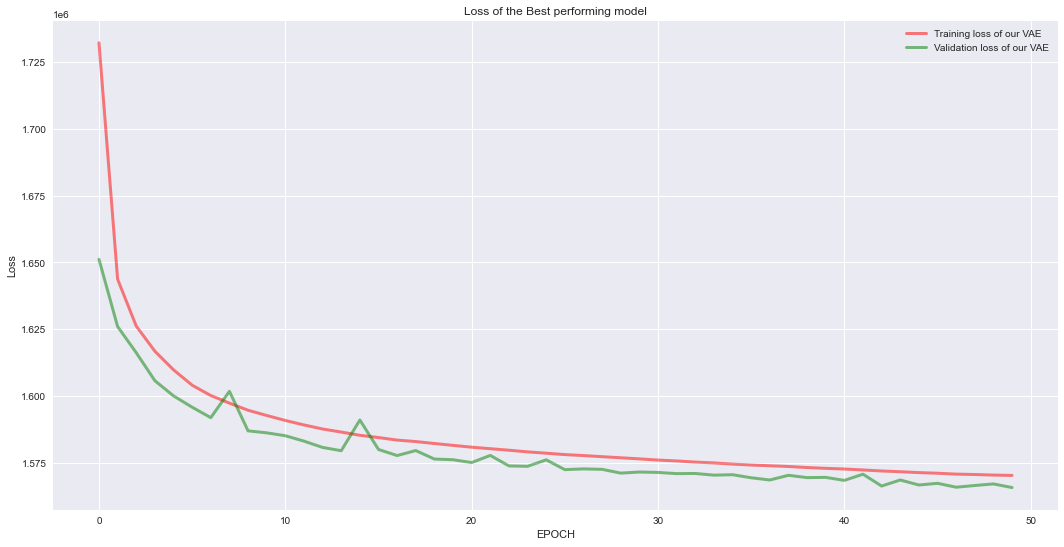

In [15]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,9)

#ax[0].plot(train_loss, c="blue", label="Training loss Best Performance", linewidth=3, alpha=0.5)
ax.plot(train_loss, c="red", label="Training loss of our VAE", linewidth=3, alpha=0.5)
ax.plot(valid_loss, c="green", label="Validation loss of our VAE", linewidth=3, alpha=0.5)
ax.legend(loc="best")
ax.set_xlabel("EPOCH")
ax.set_ylabel("Loss")
ax.set_title("Loss of the Best performing model")



In [16]:
savepath = "imgs/conv_vae"

tboard_path = os.path.join(os.getcwd(), "tboard_logs", "conv_vae")
if os.path.exists(tboard_path):
    shutil.rmtree(tboard_path)
os.makedirs(tboard_path)
tboard = SummaryWriter(tboard_path)

In [17]:
with torch.no_grad():
    for i in range(5):
        z = torch.randn(32,1024,1,1).to(device)
        sample = model.decoder(z)
    
        

torch.Size([64, 128, 128, 3])


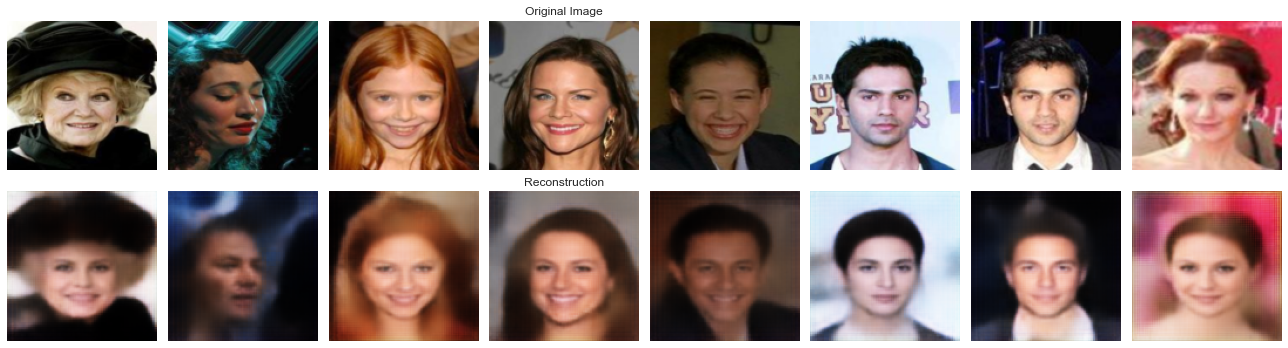

In [18]:
imgs, _ = next(iter(test_loader)) 

model.eval()
with torch.no_grad():
    recons, _, _ = model(imgs.to(device))
    recons = torch.permute(recons, (0,2,3,1))
    print(recons.size())

imgs = torch.permute(imgs, (0,2,3,1))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(imgs[i])
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i].cpu())
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

The reconstruction of our model actually looks quite good and we get nice facial features like the eybrows. A problem with the model is, that it makes all the images quite smooth, which is definetly not really desirable for faces.

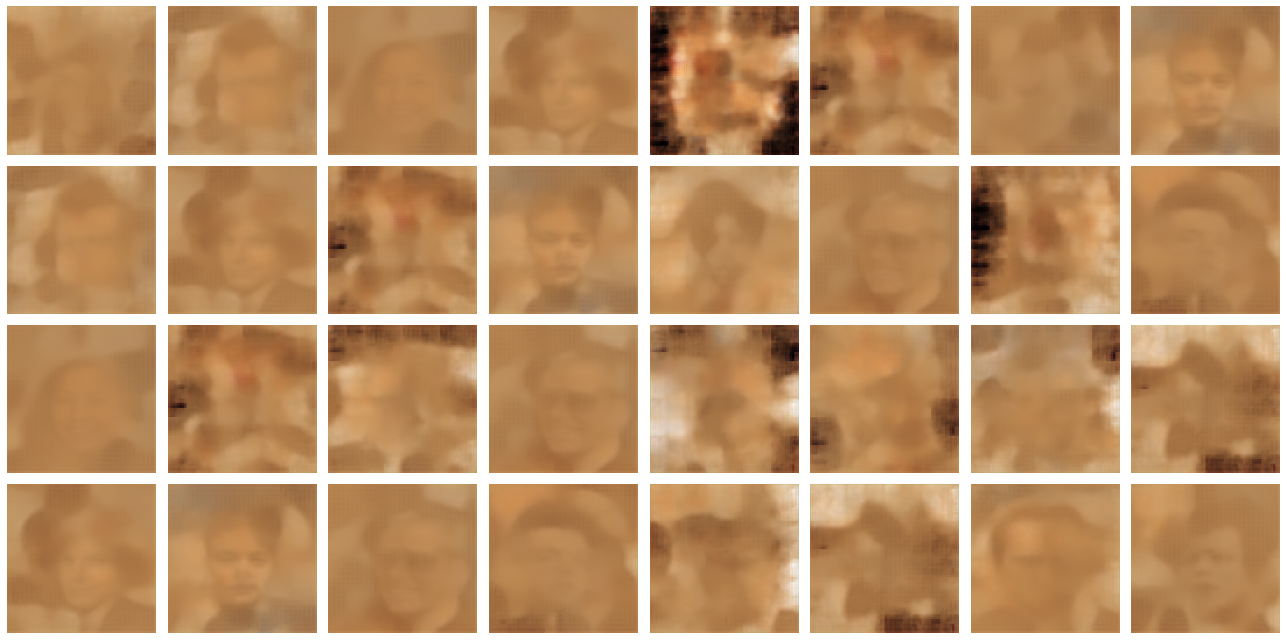

In [19]:

with torch.no_grad():
    for i in range(5):
        z = torch.randn(32,1024,1,1).to(device)
        sample = model.decoder(z)
    
sample = torch.permute(sample, (0,2,3,1))

    
fig, ax = plt.subplots(4, 8)
fig.set_size_inches(18, 9)
for i in range(4):
    for j in range(8):
        ax[i, j].imshow(sample[j+i*(j+1)].cpu())
        ax[i, j].axis("off")


plt.tight_layout()
plt.show()

We are not quite sure how to do the interpolation here. Therefore we did generate a few faces with random noise. We can see, that they are of very low contrast. This could be because of not normalizing. If you look closely, you can see quite nice facial features being generated.

In [20]:
from inception_score import inception_score

In [21]:
samples = []
with torch.no_grad():
    for i in range(5):
        z = torch.randn(32,1024,1,1).to(device)
        sample = model.decoder(z)
        samples.append(sample)
        #print(sample.size())
    
        #save_image(sample.view(32, 3, 64, 64), f"imgs/inferecence_vae/inference_{i}.png")

In [22]:
for s in samples:
    score = inception_score(s, cuda=True, batch_size=5, resize=True, splits=1)
    print(score)

f:\Uni\Cuda-Lab\Cuda_Lab\sheet06\inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(2.019616760198632, 0.0)
(1.911066365685475, 0.0)
(1.7420208177999261, 0.0)
(1.9551881212504565, 0.0)
(2.100400564694928, 0.0)


### ResVAE

In [23]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = datasets.CelebA(root="data/", split="train", transform=data_transforms['train'], download=True)
#train_dataset, subtrain_dataset =  torch.utils.data.random_split(train_dataset, [50000, len(train_dataset) - 50000]) 
test_dataset = datasets.CelebA(root="data/", split="test", transform=data_transforms['test'], download=True)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
model = ResVAE(pre_trained=True, hidden_dim=256).to(device)
res_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
res_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(res_optimizer, patience=5, factor=0.1, verbose=True)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BSZ, shuffle=False)

In [26]:
savepath = "imgs/res_vae"

tboard_path = os.path.join(os.getcwd(), "tboard_logs", "vanilla_dae")
if os.path.exists(tboard_path):
    shutil.rmtree(tboard_path)
os.makedirs(tboard_path)
tboard = SummaryWriter(tboard_path)

In [27]:
train_loss, val_loss, loss_iters = train_model(
        model=model, optimizer=res_optimizer, scheduler=res_scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=5, savepath=savepath,
        tboard=tboard
    )

Epoch 1 Iter 2544: loss 316.01184. : 100%|██████████| 2544/2544 [04:44<00:00,  8.93it/s]


    Train loss: 378.7857
    Valid loss: 1443.90856


Epoch 5 Iter 2544: loss 261.62451. : 100%|██████████| 2544/2544 [04:18<00:00,  9.85it/s]

    Train loss: 236.42882
    Valid loss: 234.70493
Training completed


Text(0.5, 1.0, 'Loss of the Best performing model')

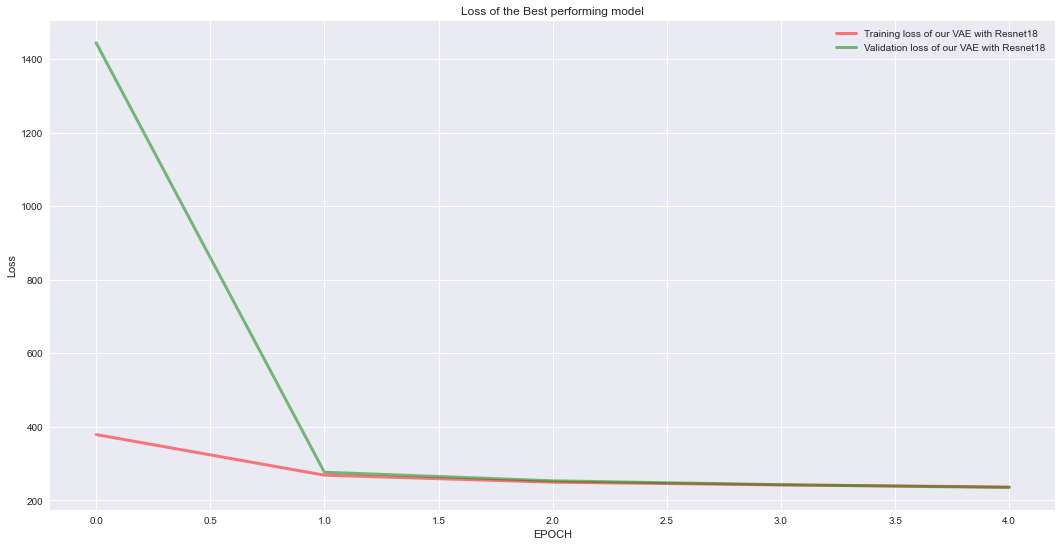

In [28]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,9)

#ax[0].plot(train_loss, c="blue", label="Training loss Best Performance", linewidth=3, alpha=0.5)
ax.plot(train_loss, c="red", label="Training loss of our VAE with Resnet18", linewidth=3, alpha=0.5)
ax.plot(val_loss, c="green", label="Validation loss of our VAE with Resnet18", linewidth=3, alpha=0.5)
ax.legend(loc="best")
ax.set_xlabel("EPOCH")
ax.set_ylabel("Loss")
ax.set_title("Loss of the Best performing model")



In [29]:
with torch.no_grad():
    for i in range(5):
        z = torch.randn(32, 256).to(device)
        sample = model.decoder(z)
    

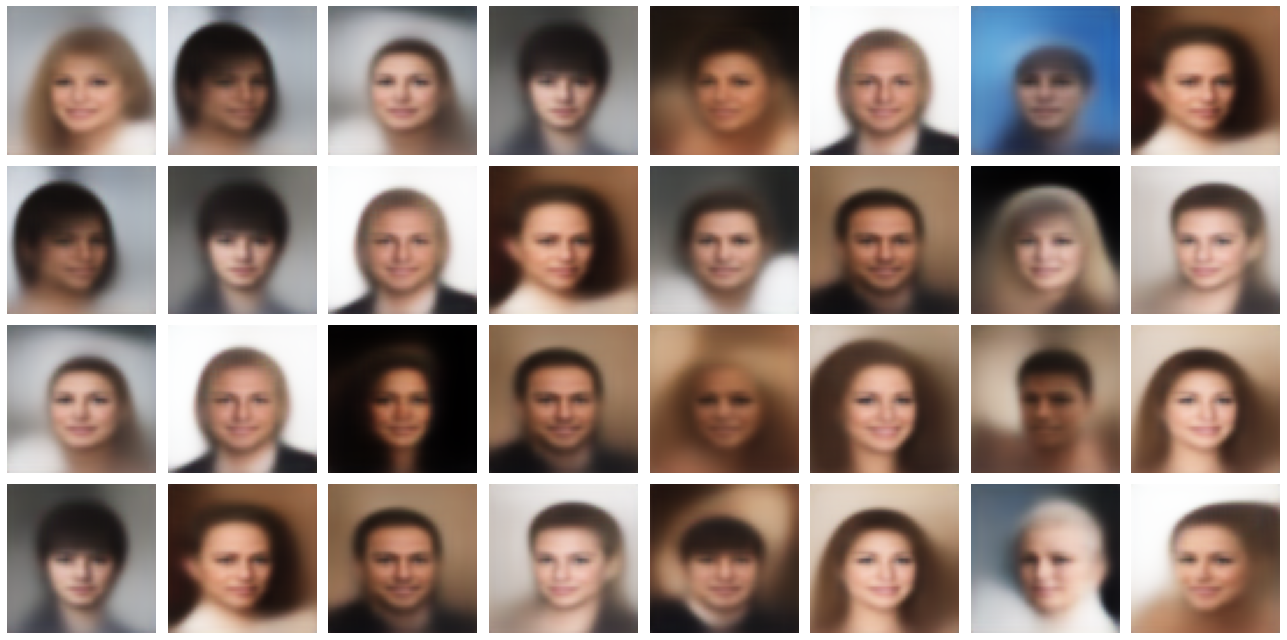

In [30]:
sample = torch.permute(sample, (0,2,3,1))

    
fig, ax = plt.subplots(4, 8)
fig.set_size_inches(18, 9)
for i in range(4):
    for j in range(8):
        ax[i, j].imshow(sample[j+i*(j+1)].cpu())
        ax[i, j].axis("off")


plt.tight_layout()
plt.show()

These faces look a lot better than the one we got with our custom VAE implementation. But they still can't compete with the generative models we saw on the internet which used for example VGG16

torch.Size([64, 64, 64, 3])


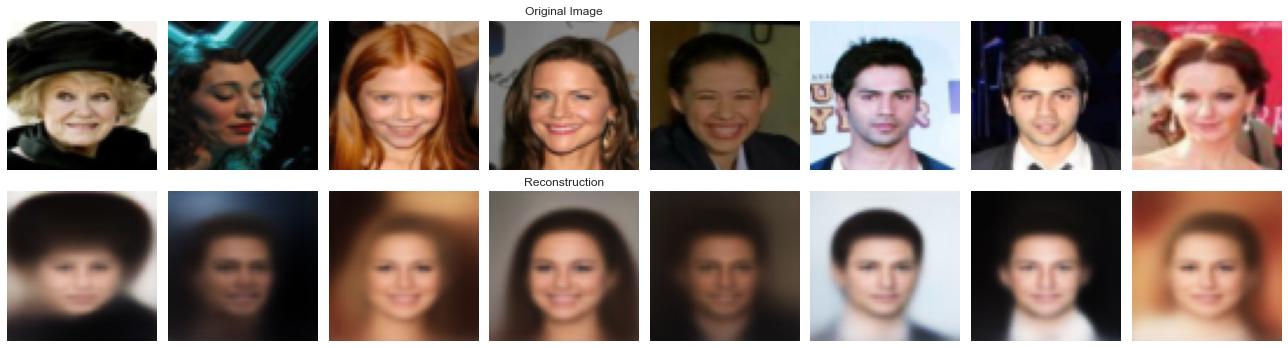

In [31]:
imgs, _ = next(iter(test_loader)) 

model.eval()
with torch.no_grad():
    recons, _ = model(imgs.to(device))
    recons = torch.permute(recons, (0,2,3,1))
    print(recons.size())

imgs = torch.permute(imgs, (0,2,3,1))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(imgs[i])
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i].cpu())
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

The reconstruction is definetly better with our Autoencoder, because it reconstructs an image that is much closer to the original one.

In [32]:
samples = []
with torch.no_grad():
    for i in range(5):
        z = torch.randn(32, 256).to(device)
        sample = model.decoder(z)
        samples.append(sample)
    
        #save_image(sample.view(32, 3, 64, 64), f"imgs/inferecence_vae/inference_{i}.png")

In [33]:
for s in samples:
    score = inception_score(s, cuda=True, batch_size=5, resize=True, splits=1)
    print(score)

f:\Uni\Cuda-Lab\Cuda_Lab\sheet06\inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(1.7226112869668697, 0.0)
(1.8105190899456538, 0.0)
(1.8670213144438477, 0.0)
(1.7647891810032141, 0.0)
(1.720956715012617, 0.0)


We can see, that the inception score is larger than the one from the model above, so the Resnet based model is better at generating images than the model we built first, since it has a lower inception score